In [1]:
import glob, h5py, math, time, os, json
from scipy.stats import norm, expon, chi2, uniform, chisquare
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

In [156]:
def read_t(folders):
    t_dict = {}
    for foldername in list(folders.keys()):
        folder=folders[foldername]
        if not os.path.exists(folder): continue
        print(folder)
        t_dict[foldername]= np.array([])
        for sub_f in [x[0] for x in os.walk(folder)]:
            #print(sub_f)
            if os.path.isfile(sub_f+'/t.txt'):
                f_txt = open(sub_f+'/t.txt', 'r')
                t = float(f_txt.readlines()[0].split('\n')[0])
                f_txt.close()
                #print(t)
                t_dict[foldername]= np.append(t_dict[foldername], [t])
        print(t_dict[foldername].shape)
    return t_dict

def read_all(folders):
    t_dict = {}
    coeffs_history, centroids_history, widths_history = {},{}, {}
    loss_history, loss_nplm_history = {}, {}
    for k in list(folders.keys()):
        folder=folders[k]
        print(folder)
        if not os.path.exists(folder): 
            print('No folder, skip.')
            continue
        
        label = k
        print(label)
        t_dict[label]= np.array([])
        coeffs_history[label]= np.array([])
        centroids_history[label]= np.array([])
        widths_history[label]= np.array([])
        loss_history[label]= np.array([])
        loss_nplm_history[label]= np.array([])
        for sub_f in [x[0] for x in os.walk(folder)]:
            if not 's' in sub_f: continue
            if os.path.isfile(sub_f+'/t.txt'): #and os.path.isfile(sub_f+'/t_f.txt'):
                f_txt = open(sub_f+'/t.txt', 'r')
                t = float(f_txt.readlines()[0].split('\n')[0])
                f_txt.close()
                if np.isnan(t):
                    print('nan')
                    continue
                t_dict[label]= np.append(t_dict[label], [t])
            else: continue
            
            if coeffs_history[label].shape[0]==0:
                coeffs_history[label]= np.expand_dims(np.load(sub_f+'/coeffs_history.npy')[-2:-1], axis=0)
                centroids_history[label]= np.expand_dims(np.load(sub_f+'/centroids_history.npy')[-2:-1], axis=0)
                widths_history[label]= np.expand_dims(np.load(sub_f+'/widths_history.npy')[-2:-1], axis=0)
                loss_history[label]= np.expand_dims(np.load(sub_f+'/loss_history.npy')[-2:-1], axis=0)
                loss_nplm_history[label]= np.expand_dims(np.load(sub_f+'/nplm_loss_history.npy')[-2:-1], axis=0)
            else:
                coeffs_history[label]= np.concatenate((coeffs_history[label], np.expand_dims(np.load(sub_f+'/coeffs_history.npy')[-2:-1], axis=0)))
                centroids_history[label]= np.concatenate((centroids_history[label], np.expand_dims(np.load(sub_f+'/centroids_history.npy')[-2:-1], axis=0)))
                widths_history[label]= np.concatenate((widths_history[label], np.expand_dims(np.load(sub_f+'/widths_history.npy')[-2:-1], axis=0)))
                loss_history[label]= np.concatenate((loss_history[label], np.expand_dims(np.load(sub_f+'/loss_history.npy')[-2:-1], axis=0)))
                loss_nplm_history[label]= np.concatenate((loss_nplm_history[label], np.expand_dims(np.load(sub_f+'/nplm_loss_history.npy')[-2:-1], axis=0)))
        print(t_dict[label].shape)    
    return t_dict, coeffs_history, centroids_history, widths_history, loss_history, loss_nplm_history 

def Z_score_chi2(t,df):
    sf = chi2.sf(t, df)
    Z  = -norm.ppf(sf)
    return Z

def Z_score_norm(t,mu, std):
    sf = norm.sf(t, mu, std)
    Z  = -norm.ppf(sf)
    return Z

def plot_1distribution(t, df, xmin=0, xmax=300, nbins=10, save=False, ymax=None, output_path='', save_name='', label=''):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!). 
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    Z_obs     = norm.ppf(chi2.cdf(np.median(t), df))
    t_obs_err = 1.2533*np.std(t)*1./np.sqrt(t.shape[0])
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t)+t_obs_err, df))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t)-t_obs_err, df))
    label  = 'sample %s\nsize: %i \nmedian: %s, std: %s\n'%(label, t.shape[0], str(np.around(np.median(t), 2)),str(np.around(np.std(t), 2)))
    label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    binswidth = (xmax-xmin)*1./nbins
    h = plt.hist(t, weights=np.ones_like(t)*1./(t.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=14) 
    plt.legend(prop=font, frameon=False)
    plt.xlabel('t', fontsize=18, fontname="serif")
    plt.ylabel('Probability', fontsize=18, fontname="serif")
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if ymax !=None:
        plt.ylim(0., ymax)
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_distribution.pdf')
            print('saved at %s'%(output_path+ save_name+'_distribution.pdf'))
    plt.show()
    plt.close(fig)
    return

def plot_2distribution_Chi2Ref(t1, t2, df, xmin=0, xmax=300, ymax=None, nbins=10, save=False, output_path='', label1='1', label2='2', save_name='', print_Zscore=True):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!).
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    binswidth = (xmax-xmin)*1./nbins
    # t1
    Z_obs     = Z_score_chi2(np.median(t1), df)
    t_obs_err = 1.2533*np.std(t1)*1./np.sqrt(t1.shape[0])
    Z_obs_p   = Z_score_chi2(np.median(t1)+t_obs_err, df)
    Z_obs_m   = Z_score_chi2(np.median(t1)-t_obs_err, df)
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label1, t1.shape[0], str(np.around(np.median(t1), 2)),str(np.around(np.std(t1), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    
    h = plt.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t1.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h[0])
    # t2
    Z_obs     = Z_score_chi2(np.median(t2), df)
    t_obs_err = 1.2533*np.std(t2)*1./np.sqrt(t2.shape[0])
    Z_obs_p   = Z_score_chi2(np.median(t2)+t_obs_err, df)
    Z_obs_m   = Z_score_chi2(np.median(t2)-t_obs_err, df)
    t_empirical = np.sum(1.*(t1>np.mean(t2)))*1./t1.shape[0]
    empirical_lim = '='
    if t_empirical==0:
        empirical_lim='>'
        t_empirical = 1./t1.shape[0]
    t_empirical_err = t_empirical*np.sqrt(1./np.sum(1.*(t1>np.mean(t2))+1./t1.shape[0]))
    Z_empirical = norm.ppf(1-t_empirical)
    Z_empirical_m = norm.ppf(1-(t_empirical+t_empirical_err))
    Z_empirical_p = norm.ppf(1-(t_empirical-t_empirical_err))
                                          
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label2, t2.shape[0], str(np.around(np.median(t2), 2)),str(np.around(np.std(t2), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s) \n'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        label += 'empirical Z %s %s (+%s/-%s)'%(empirical_lim, str(np.around(Z_empirical, 2)), str(np.around(Z_empirical_p-Z_empirical, 2)), str(np.around(Z_empirical-Z_empirical_m, 2)))
    h = plt.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), color='#8dd3c7', ec='seagreen',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t2.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='seagreen', marker='o', ls='')
    max2 = np.max(h[0])
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=20) #weight='bold', style='normal', 
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    plt.ylim(0., 1.2*np.maximum(max1, max2))#np.max(chi2.pdf(x, df))*1.3)
    if ymax !=None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_2distribution.pdf')
    plt.show()
    plt.close()
    return

def plot_2distribution_NormRef(t1, t2, mu, std, xmin=0, xmax=300, ymax=None, nbins=10, save=False, output_path='', label1='1', label2='2', save_name='', print_Zscore=True):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!).
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    binswidth = (xmax-xmin)*1./nbins
    # t1
    Z_obs     = Z_score_norm(np.median(t1), mu, std,)
    t_obs_err = 1.2533*np.std(t1)*1./np.sqrt(t1.shape[0])
    Z_obs_p   = Z_score_norm(np.median(t1)+t_obs_err, mu, std,)
    Z_obs_m   = Z_score_norm(np.median(t1)-t_obs_err, mu, std,)
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label1, t1.shape[0], str(np.around(np.median(t1), 2)),str(np.around(np.std(t1), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    
    h = plt.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t1.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h[0])
    # t2
    Z_obs     = Z_score_norm(np.median(t2), mu, std,)
    t_obs_err = 1.2533*np.std(t2)*1./np.sqrt(t2.shape[0])
    Z_obs_p   = Z_score_norm(np.median(t2)+t_obs_err, mu, std,)
    Z_obs_m   = Z_score_norm(np.median(t2)-t_obs_err, mu, std,)
    t_empirical = np.sum(1.*(t1>np.mean(t2)))*1./t1.shape[0]
    empirical_lim = '='
    if t_empirical==0:
        empirical_lim='>'
        t_empirical = 1./t1.shape[0]
    t_empirical_err = t_empirical*np.sqrt(1./np.sum(1.*(t1>np.mean(t2))+1./t1.shape[0]))
    Z_empirical = norm.ppf(1-t_empirical)
    Z_empirical_m = norm.ppf(1-(t_empirical+t_empirical_err))
    Z_empirical_p = norm.ppf(1-(t_empirical-t_empirical_err))
                                          
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label2, t2.shape[0], str(np.around(np.median(t2), 2)),str(np.around(np.std(t2), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s) \n'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        label += 'empirical Z %s %s (+%s/-%s)'%(empirical_lim, str(np.around(Z_empirical, 2)), str(np.around(Z_empirical_p-Z_empirical, 2)), str(np.around(Z_empirical-Z_empirical_m, 2)))
    h = plt.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), color='#8dd3c7', ec='seagreen',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t2.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='seagreen', marker='o', ls='')
    max2 = np.max(h[0])
    # plot reference normal
    x  = np.linspace(norm.ppf(0.0001, mu, std), norm.ppf(0.9999, mu, std), 100)
    plt.plot(x, norm.pdf(x, mu, std),'midnightblue', lw=5, alpha=0.8, label=r'$\rm N(%s,\, %s)$'%(str(np.around(mu, 2)), str(np.around(std, 2))))
    font = font_manager.FontProperties(family='serif', size=20) #weight='bold', style='normal', 
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    plt.ylim(0., 1.2*np.maximum(max1, max2))#np.max(chi2.pdf(x, df))*1.3)
    if ymax !=None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_2distribution.pdf')
    plt.show()
    plt.close()
    return

def Plot_Percentiles_ref(tvalues_check, df, patience=1, wc=None, ymax=300, ymin=0, save=False, save_path='', file_name=''):
    '''
    The funcion creates the plot of the evolution in the epochs of the [2.5%, 25%, 50%, 75%, 97.5%] quantiles of the toy sample distribution.
    The percentile lines for the target chi2 distribution are shown as a reference.
    
    patience:      (int) interval between two check points (epochs).
    tvalues_check: (numpy array shape (N_toys, N_check_points)) array of t=-2*loss
    df:            (int) chi2 degrees of freedom
    '''
    colors = ['seagreen', 'mediumseagreen', 'lightseagreen', '#2c7fb8', 'midnightblue']
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    epochs_check = []
    nr_check_points = tvalues_check.shape[1]
    for i in range(nr_check_points):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
    fig = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    quantiles   = [2.5, 25, 50, 75, 97.5]
    percentiles = np.array([])
    plt.xlabel('Training Epochs', fontsize=16, fontname="serif")
    plt.ylabel('t', fontsize=16, fontname="serif")
    plt.ylim(ymin, ymax)
    if wc != None:
        plt.title('Weight Clipping = '+wc, fontsize=16,  fontname="serif")
    for i in range(tvalues_check.shape[1]):
        percentiles_i = np.percentile(tvalues_check[:, i], quantiles)
        percentiles_i = np.expand_dims(percentiles_i, axis=1)
        if not i: percentiles = percentiles_i.T
        else: percentiles = np.concatenate((percentiles, percentiles_i.T))
    legend = []
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, percentiles[:, j], marker='.', linewidth=3, color=colors[j])
        legend.append(str(quantiles[j])+' % quantile')
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, chi2.ppf(quantiles[j]/100., df=df, loc=0, scale=1)*np.ones_like(epochs_check),
                color=colors[j], ls='--', linewidth=1)
        if j==0: legend.append("Target "+r"$\chi^2(df=$"+str(df)+")")
    font = font_manager.FontProperties(family='serif', size=16)         
    plt.legend(legend, prop=font)
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if save:
        if save_path=='': print('argument save_path is not defined. The figure will not be saved.')
        else:
            if file_name=='': file_name = 'PlotPercentiles'
            else: file_name += '_PlotPercentiles'
            fig.savefig(save_path+file_name+'.pdf')
    plt.show()
    plt.close(fig)
    return

# Study hyperparameters on bkg-only toys

In [239]:
## read output from folders
folder_root = './dictionary-learning/new-tf/out/toy/reference/'

folders = [ 
#    'M10_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
#    'M10_Lcoeffs1e-09_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
#    'M60_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width2.6_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
#    'M60_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
#    'M60_Lcoeffs1e-09_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
#    'M60_Lcoeffs1e-11_Lwidths0_Lentropy0.01_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
#    'M120_Lcoeffs1e-09_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
    'M50_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR500_ND50_background/res-scale_0.01_coeffs_clip1000000.0/',

]

t_dict = {}
coeffs_history, centroids_history, widths_history = {},{}, {}
loss_history, loss_nplm_history = {}, {}
for folder in folders:
    print(folder)
    label = folder
    print(label)
    t_dict[label]= np.array([])
    coeffs_history[label]= np.array([])
    centroids_history[label]= np.array([])
    widths_history[label]= np.array([])
    loss_history[label]= np.array([])
    loss_nplm_history[label]= np.array([])
    for sub_f in [x[0] for x in os.walk(folder_root+folder)]:
        if not 's' in sub_f: continue
        if os.path.isfile(sub_f+'/t.txt'): #and os.path.isfile(sub_f+'/t_f.txt'):
            f_txt = open(sub_f+'/t.txt', 'r')
            t = float(f_txt.readlines()[0].split('\n')[0])
            f_txt.close()
            if np.isnan(t):
                print('nan')
                continue
            t_dict[label]= np.append(t_dict[label], [t])
        else: continue
        
        if coeffs_history[label].shape[0]==0:
            coeffs_history[label]= np.expand_dims(np.load(sub_f+'/coeffs_history.npy'), axis=0)
            centroids_history[label]= np.expand_dims(np.load(sub_f+'/centroids_history.npy'), axis=0)
            widths_history[label]= np.expand_dims(np.load(sub_f+'/widths_history.npy'), axis=0)
            loss_history[label]= np.expand_dims(np.load(sub_f+'/loss_history.npy'), axis=0)
            loss_nplm_history[label]= np.expand_dims(np.load(sub_f+'/nplm_loss_history.npy'), axis=0)
        else:
            coeffs_history[label]= np.concatenate((coeffs_history[label], np.expand_dims(np.load(sub_f+'/coeffs_history.npy'), axis=0)))
            centroids_history[label]= np.concatenate((centroids_history[label], np.expand_dims(np.load(sub_f+'/centroids_history.npy'), axis=0)))
            widths_history[label]= np.concatenate((widths_history[label], np.expand_dims(np.load(sub_f+'/widths_history.npy'), axis=0)))
            loss_history[label]= np.concatenate((loss_history[label], np.expand_dims(np.load(sub_f+'/loss_history.npy'), axis=0)))
            loss_nplm_history[label]= np.concatenate((loss_nplm_history[label], np.expand_dims(np.load(sub_f+'/nplm_loss_history.npy'), axis=0)))
    
    print(t_dict[label].shape)    


M50_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR500_ND50_background/res-scale_0.01_coeffs_clip1000000.0/
M50_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR500_ND50_background/res-scale_0.01_coeffs_clip1000000.0/
(41,)


M50_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR500_ND50_background/res-scale_0.01_coeffs_clip1000000.0/
50
(41,)
(41,)
263.902478
M50_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR500_ND50_background/res-scale_0.01_coeffs_clip1000000.0/
263.902478


/var/folders/t_/9vmmnz591vn599s7hm98kz480000gn/T/ipykernel_90200/574361874.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x[y>0.0005], y[y>0.0005],#chi2.pdf(x, df),


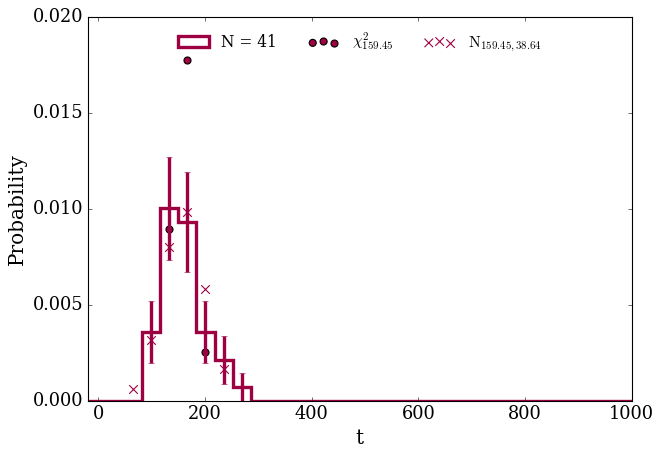

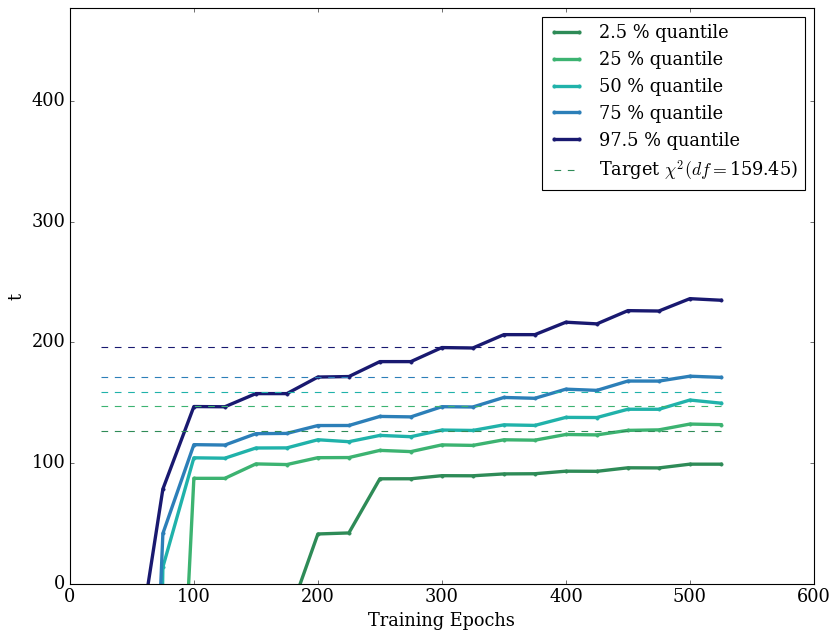

In [241]:
#evaluaiton plots
colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2', 'darkblue', 'midnightblue']
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
i=0
for k in list(t_dict.keys()):
    print(k)
    M = int(k.split('M')[-1].split('_')[0])
    print(M)
    t = t_dict[k]
    print(t.shape)
    t = t[~np.isnan(t)]
    print(t.shape)
    if t.shape[0]==0: continue
    print(np.max(t))
    fig  = plt.figure(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    ax= fig.add_axes([0.1, 0.1, 0.85, 0.8])
    df = np.around(np.mean(t),2)#np.around(np.quantile(t, 0.5), 2)
    xmin, xmax, nbins = -20, 1000, 30
    bins      = np.linspace(xmin, xmax, nbins+1)
    binswidth = (xmax-xmin)*1./nbins
    print(k)
    print(np.max(t))
    h = plt.hist(t, weights=np.ones_like(t)*1./(t.shape[0]*binswidth), histtype='step', color=colors[i], 
                 #ec='black', alpha=0.5, 
                 lw=3,bins=bins, 
                 label='N = %i'%(t.shape[0]),#'M = %s'%(k)
                )
    err = np.sqrt(h[0]/(t.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color=colors[i], #color='black', 
                 marker='', ls='', lw=3)
    # plot reference chi2
    if t.shape[0]:
        y = np.array([chi2.cdf(bins[i+1], df)-chi2.cdf(bins[i], df) for i in range(len(bins)-1)])*1./binswidth
        plt.scatter(x[y>0.0005], y[y>0.0005],#chi2.pdf(x, df),
                 #color='black',#
                 color=colors[i], 
                 marker='o', edgecolors='black',
                 s=40,
                label=r'$\chi^2_{%s}$'%(str(df)))

        y = np.array([norm.cdf(bins[i+1], np.mean(t), np.std(t))-norm.cdf(bins[i], np.mean(t), np.std(t)) for i in range(len(bins)-1)])*1./binswidth
        plt.scatter(x[y>0.0005], y[y>0.0005],#chi2.pdf(x, df),
                 #color='black',#
                 color=colors[i], 
                 marker='x', edgecolors='black',
                 s=60,
                label=r'$\rm N_{%s, %s}$'%(str(np.around(np.mean(t), 2)), str(np.around(np.std(t), 2))))
    #plt.errorbar(x[y>0.0005], y[y>0.0005], yerr=err[y>0.0005], color=colors[i], marker='', ls='')
    i+=1
    font = font_manager.FontProperties(family='serif', size=14) 
    plt.legend(prop=font, ncol=5, loc='upper center', frameon=False)
    plt.xlabel('t', fontsize=18, fontname="serif")
    plt.ylabel('Probability', fontsize=18, fontname="serif")
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    #plt.xscale('log')
    plt.xlim(bins[0], bins[-1])
    #plt.ylim(0, 0.5)
    ymax=None
    if ymax !=None:
        plt.ylim(0., ymax)
    plt.savefig('%s/%s/ref-distributions.pdf'%(folder_root, k))
    plt.show()
    plt.close(fig)

    t_evolution = -2*loss_nplm_history[k]
    t_evolution = t_evolution[~np.any(np.isnan(t_evolution), axis=1)]
    Plot_Percentiles_ref(t_evolution, df=np.around(df, 2), patience=25, wc=None, ymax=np.around(df, 0)*3, ymin=0, save=True, save_path='%s/%s/'%(folder_root, k), file_name='evolution_df%i'%(int(np.around(df, 0))))
    #Plot_Percentiles_ref(t_evolution, df=M*5+M, patience=5, wc=None, ymax=(M*2*5+M)*3, ymin=0, save=True, save_path='%s/%s/'%(folder_root, k), file_name='evolution_df%i'%(M*5+M))

# study signal injection

In [194]:
folders = {
   'ref': './dictionary-learning/new-tf/out/toy/reference/M10_Lcoeffs1e-09_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
   'bbh': './dictionary-learning/new-tf/out/toy/sliding-window/M10_Lcoeffs1e-09_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_bbh/res-scale_0.01_coeffs_clip1000000/',
   }

In [192]:
folders = {
   'ref': './dictionary-learning/new-tf/out/toy/reference/M10_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
   'bbh': './dictionary-learning/new-tf/out/toy/sliding-window/M10_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_bbh/res-scale_0.01_coeffs_clip1000000/',
   }

In [197]:
folders = {
   'ref': './dictionary-learning/new-tf/out/toy/reference/M60_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
   'bbh': './dictionary-learning/new-tf/out/toy/sliding-window/M60_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_bbh/res-scale_0.01_coeffs_clip1000000/',
   }

In [200]:
folders = {
   'ref': './dictionary-learning/new-tf/out/toy/reference/M60_Lcoeffs1e-11_Lwidths0_Lentropy0.01_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_background/res-scale_0.01_coeffs_clip1000000/',
   'bbh': './dictionary-learning/new-tf/out/toy/sliding-window/M60_Lcoeffs1e-11_Lwidths0_Lentropy0.01_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR600_ND60_bbh/res-scale_0.01_coeffs_clip1000000/',
   }

In [242]:
folders = {
   'ref': './dictionary-learning/new-tf/out/toy/reference/M50_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR500_ND50_background/res-scale_0.01_coeffs_clip1000000.0/',
   'bbh': './dictionary-learning/new-tf/out/toy/signals/sliding-window/M50_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR500_ND50_bbh/res-scale_0.01_coeffs_clip1000000.0/',
   }

In [243]:
# read from folders
#t_dict = read_t(folders)
t_dict, coeffs_history, centroids_history, widths_history, loss_history, loss_nplm_history = read_all(folders)

./dictionary-learning/new-tf/out/toy/reference/M50_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR500_ND50_background/res-scale_0.01_coeffs_clip1000000.0/
ref
(41,)
./dictionary-learning/new-tf/out/toy/signals/sliding-window/M50_Lcoeffs1e-11_Lwidths0_Lentropy1.0_epochs1000_subepochs100_width4.0_train-coeffs_train-centroids_NR500_ND50_bbh/res-scale_0.01_coeffs_clip1000000.0/
bbh
(21,)


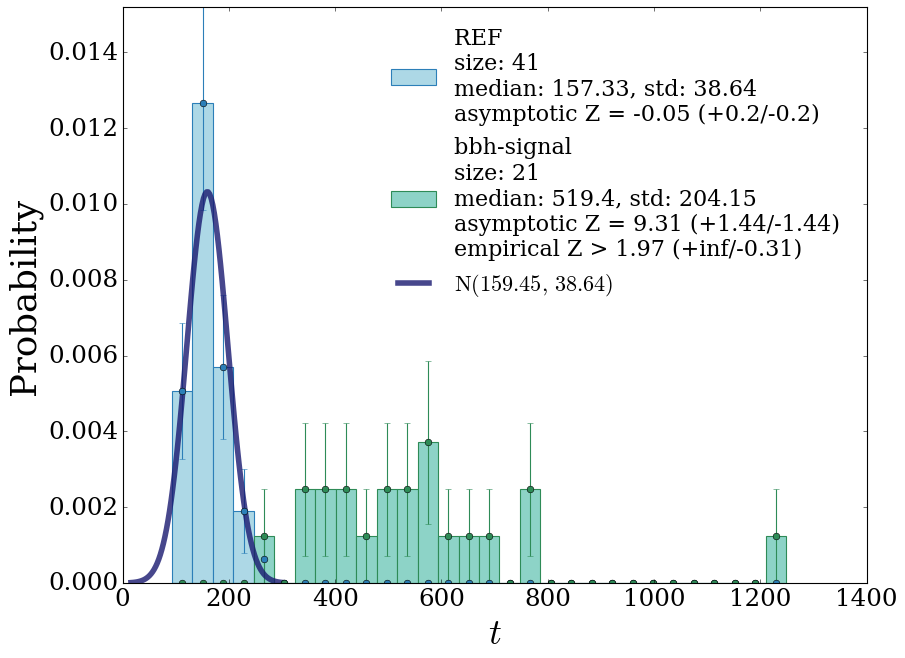

In [244]:
t1 = t_dict['ref']
t1 = t1[~np.isnan(t1)]
i=0
for k in list(t_dict.keys()):
    folder =folders[k]
    if k=='ref': continue
    t2 = t_dict[k]
    t2 = t2[~np.isnan(t2)]
    if t2.shape[0]==0: 
        i+=1
        continue
    plot_2distribution_NormRef(t1, t2, mu=np.mean(t1),std= np.std(t1),
                                     xmin=np.min(t1), xmax=np.max(t2), #ymax=0.03, 
                                     nbins=30, save=True, output_path=folder, 
                                     label1='REF', label2='%s-signal'%(k), save_name='%s-signal'%(k), print_Zscore=True)
    i+=1

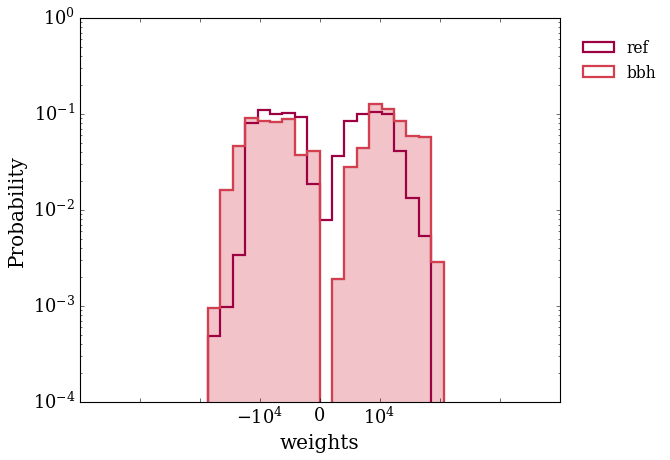

In [276]:
colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2', 'darkblue', 'midnightblue']
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

xmin, xmax, nbins = -31000, 31000, 30
bins      = np.linspace(xmin, xmax, nbins+1)

binswidth = (xmax-xmin)*1./nbins
x=0.5*(bins[1:]+bins[:-1])
i=0
N=len(list(t_dict.keys()))
for k in list(t_dict.keys()):
    folder =folders[k]
    if k=='ref': continue
    fig  = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    ax= fig.add_axes([0.15, 0.15, 0.5, 0.8])
    for k in list(t_dict.keys()):
        M = k.split('M')[-1].split('_')[0]
        Lrep = k.split('_Lrep')[-1].split('_')[0]
        clip = k.split('clip')[-1].split('/')[0]
        width= k.split('_width')[-1].split('_')[0]
        if coeffs_history[k].shape[0]==0: 
            i+=1
            continue
        t=coeffs_history[k][:, -1, :].reshape((-1,))
        t=t[~np.isnan(t)]
        
        plt.hist(t, bins=bins, histtype='step', color=colors[i], 
                 label=k,lw=2, weights=np.ones_like(t)*1./(t.shape[0])
                )
        if k!='ref':
            plt.hist(t, bins=bins, histtype='stepfilled', color=colors[i], alpha=0.3,
                 lw=2, weights=np.ones_like(t)*1./(t.shape[0])
                    )
        i+=1
    font = font_manager.FontProperties(family='serif', size=14) 
    plt.legend(prop=font, ncol=1, loc='upper left', frameon=False, bbox_to_anchor=(1.02, 0.98)
              )
    plt.xlabel(r'weights', fontsize=18, fontname="serif")
    
    plt.ylabel('Probability', fontsize=18, fontname="serif")
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    plt.yscale('log')
    #
    #plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    #plt.gca().xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.LogFormatterSciNotation(base=10, minor_thresholds=(200000, 200000),  labelOnlyBase=False))
    #ax.ticklabel_format(axis='both', style='sci',)
    #plt.xlim(-321, 321)
    #plt.ylim(0.001, 1)
    #ax.set_xscale('log')
    #plt.savefig('%s/all_weights_width%s_sig.pdf'%(folders['ref'], width))
    plt.savefig('%s/all_weights.pdf'%(folder))
    plt.show()

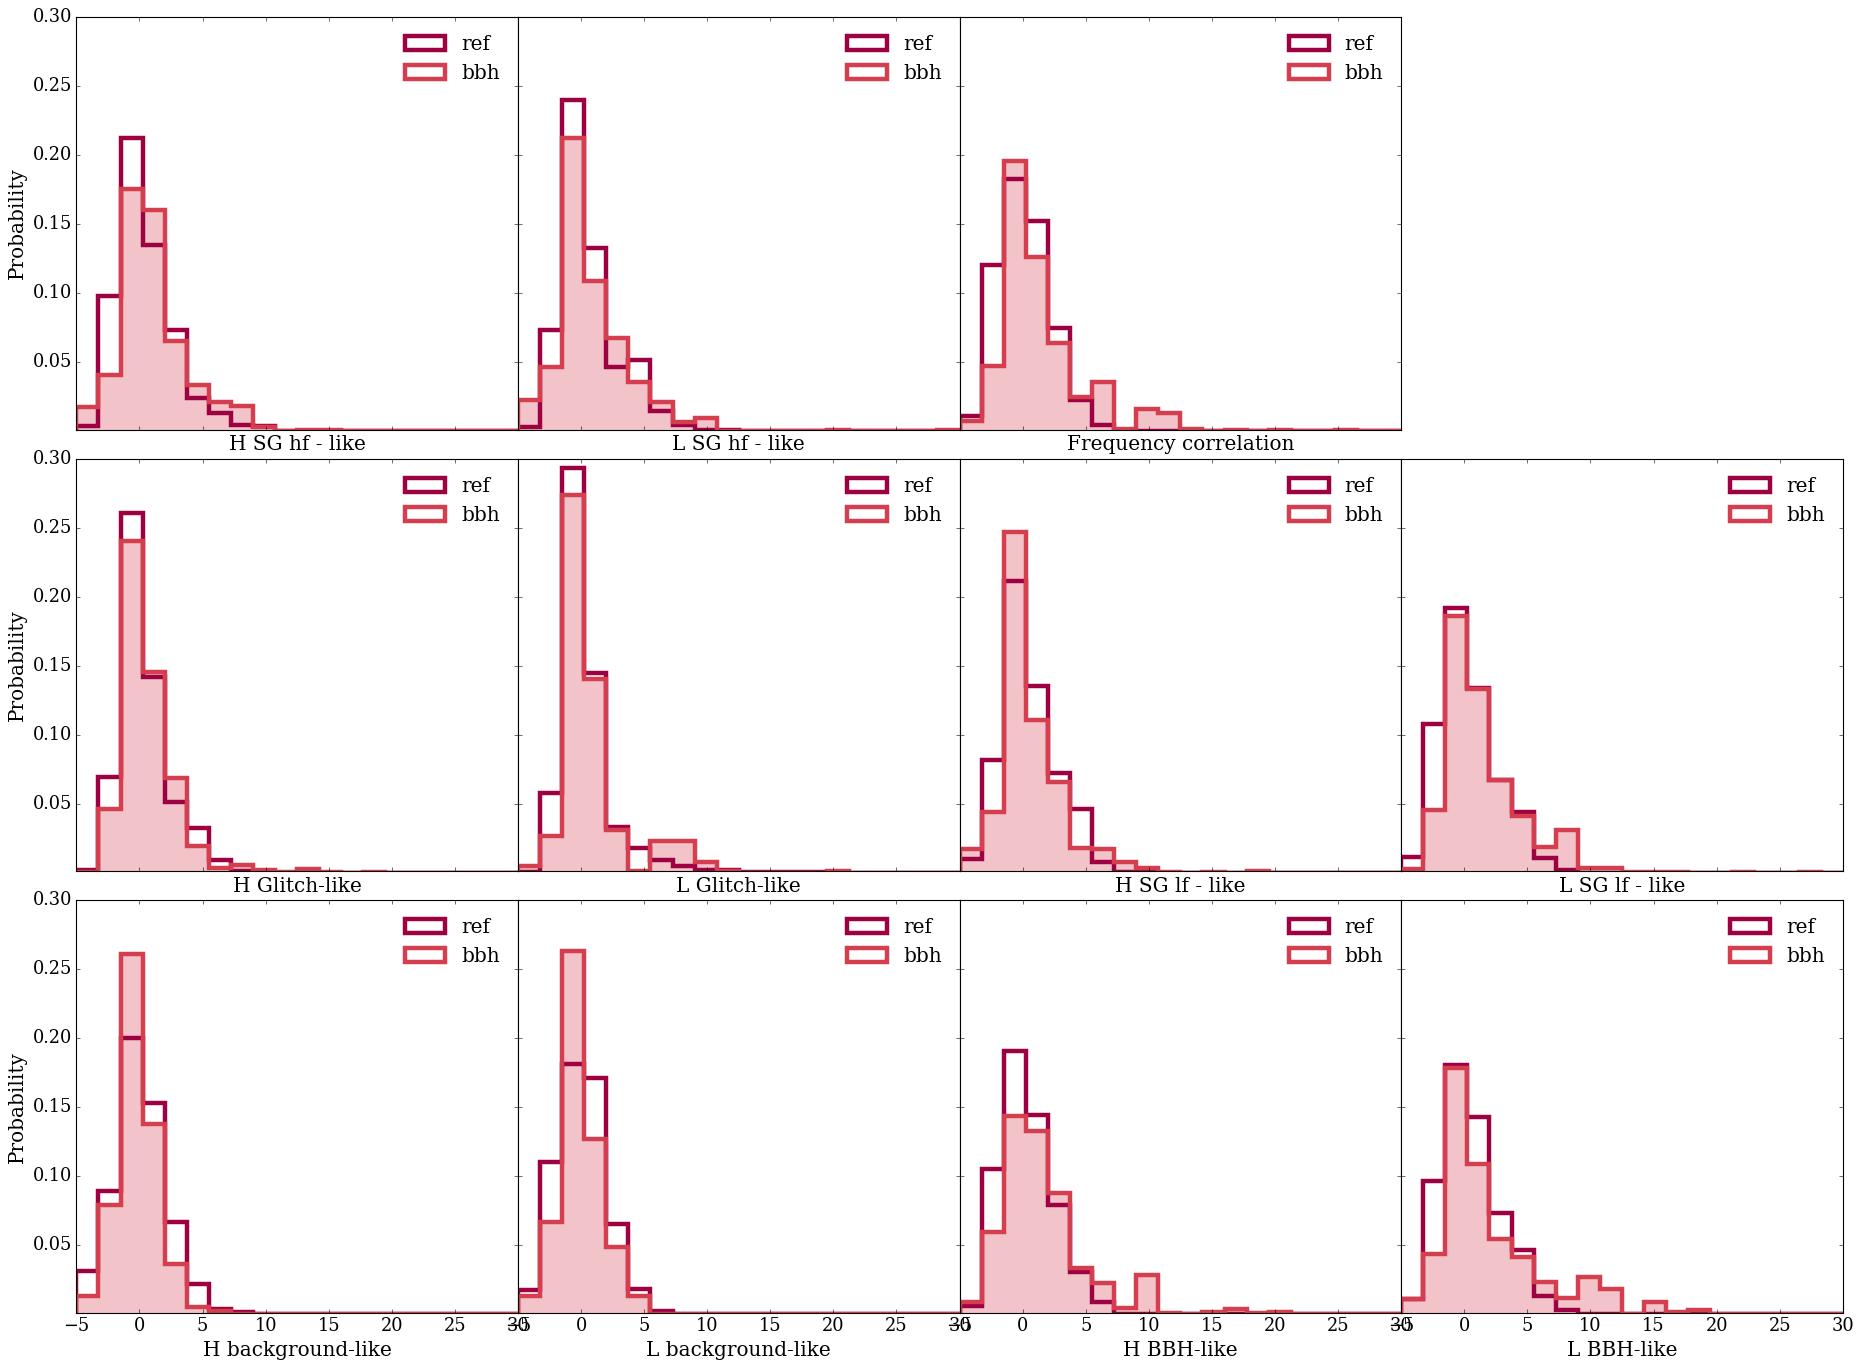

In [248]:
labels_vars=["H background-like", "L background-like", "H BBH-like",
        "L BBH-like", "H Glitch-like", "L Glitch-like", "H SG lf - like",
        "L SG lf - like", "H SG hf - like", "L SG hf - like",
        "Frequency correlation"]

xmin, xmax, nbins = -5, 30, 20
bins      = np.linspace(xmin, xmax, nbins+1)
binswidth = (xmax-xmin)*1./nbins
font = font_manager.FontProperties(family='serif', size=18) 
i=0
for k in list(t_dict.keys()):
    if k==list(t_dict.keys())[0]: 
        i+=1
        continue
    if coeffs_history[k].shape[0]==0: continue
    M = folders[k].split('/')[-3].split('M')[-1].split('_')[0]
    Lrep = folders[k].split('/')[-3].split('_Lentropy')[-1].split('_')[0]
    clip = folders[k].split('/')[-2].split('clip')[-1].split('/')[0]
    width= folders[k].split('/')[-3].split('_width')[-1].split('_')[0]
    fig  = plt.figure(figsize=(6*4, 6*4))
    fig.patch.set_facecolor('white')
    for d in range(11):
        ax= fig.add_axes([0.05+(d%4)*(0.92/4), 0.15+int(d/4)*0.92/4, 0.92/4, 0.86/4])
        if k!=list(t_dict.keys())[0]:
            t=centroids_history[list(t_dict.keys())[0]][:, -1, :, d].reshape((-1,))
            plt.hist(t, bins=bins, histtype='step', color=colors[0], 
                     label='ref',#r'M = %s, $\lambda_{\rm REP}=%s$, $\sigma=%s$, clip=%s'%(M, Lrep, width, clip),
                     lw=4, weights=np.ones_like(t)*1./(t.shape[0]*binswidth))
            #plt.hist(t, bins=bins, color=colors[0], histtype='stepfilled', alpha=0.3,
            #        weights=np.ones_like(t)*1./(t.shape[0]*binswidth))
        t=centroids_history[k][:, -1, :, d].reshape((-1,))
        plt.hist(t, bins=bins, histtype='step', color=colors[i], 
                 label='%s'%(k),#r'M = %s, $\lambda_{\rm ENTR}=%s$, $\sigma=%s$, clip=%s'%(M, Lrep, width, clip),
                 lw=4, weights=np.ones_like(t)*1./(t.shape[0]*binswidth))    
        plt.hist(t, bins=bins, color=colors[i], histtype='stepfilled', alpha=0.3,
                    weights=np.ones_like(t)*1./(t.shape[0]*binswidth))
        plt.legend(prop=font, ncol=1, loc='upper right', frameon=False)
        plt.xlabel(labels_vars[d], fontsize=18, fontname="serif")
        if d%4==0:
            plt.ylabel('Probability', fontsize=18, fontname="serif")
        else:
            ax.tick_params(axis='y', which='both', labelleft=False)
        if int(d/4)>0:
            ax.tick_params(axis='x', which='both', labelbottom=False)
            
        plt.yticks(fontsize=16, fontname="serif")
        plt.xticks(fontsize=16, fontname="serif")
        #plt.yscale('log')
        plt.ylim(0.001, 0.3)
        #plt.xscale('log')#(-0.1, 1.1)
    plt.savefig('%s/centroids_distribution.pdf'%(folders[k]))
    plt.show()
    i+=1